# **SWSN project. Fake News detection and correction - dataset analysis** 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
import spacy
import re


nlp = spacy.load("es_core_news_sm")

def preprocess_spanish(text):
    """
    Preprocess Spanish text:
    - lowercase
    - remove digits
    - tokenize
    - remove stopwords
    - lemmatize
    - keep alphabetic tokens only
    """
    text = text.lower()
    text = re.sub(r"\d+", "", text)

    doc = nlp(text)
    tokens = [
        token.lemma_
        for token in doc
        if token.is_alpha and not token.is_stop
    ]
    
    return " ".join(tokens)


In [13]:
df = pd.read_csv("data.csv", encoding="latin-1")

X = df["TEXT"]
y = df["CATEGORY"]

label_counts = y.value_counts()

print("Label distribution:")
print(label_counts)

print("\nFake news (0):", label_counts.get(0, 0))
print("True news (1):", label_counts.get(1, 0))

Label distribution:
CATEGORY
1    286
0    286
Name: count, dtype: int64

Fake news (0): 286
True news (1): 286


In [18]:
X = X.apply(preprocess_spanish)
CountVec = CountVectorizer(ngram_range=(1,1))
CountData = CountVec.fit_transform(X)

# count_data = pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out())
# df.to_csv("count_data.csv", index=False)

In [9]:
count_data = None
chunksize = 1_000 # adjustable
for chunk in pd.read_csv('count_data.csv', chunksize=chunksize, index_col=0):
    if count_data is None:
        count_data = chunk
    else:
        count_data = pd.concat([count_data, chunk], ignore_index=True)
    print(len(count_data))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
44898


## **a) Most frequent words** ##

In [20]:
word_totals = count_data.sum(axis=0)
words_totals_true = count_data[y == 1].sum(axis=0)
words_totals_fake = count_data[y == 0].sum(axis=0)

total_terms = count_data.values.sum()
print(f"Total number of terms in the collection: {total_terms}")
print(f"Total number of different terms in the collection: {count_data.shape[1]}")
print()

most_frequent_words = word_totals.sort_values(ascending=False).head(10)
print("Most frequent words across ALL articles:")
print(most_frequent_words)

most_frequent_words_true = words_totals_true.sort_values(ascending=False).head(10)
print("Most frequent words across TRUE articles:")
print(most_frequent_words_true)
print(f"Total number of terms in the TRUE  collection: {total_terms}")
print()

most_frequent_words_fake = words_totals_fake.sort_values(ascending=False).head(10)
print("Most frequent words across FAKE articles:")
print(most_frequent_words_fake)

Total number of terms in the collection: 123612
Total number of different terms in the collection: 16454

Most frequent words across ALL articles:
él             1046
persona         746
vacuna          634
país            601
virus           512
gobierno        478
caso            464
salud           400
coronavirus     370
mujer           357
dtype: int64
Most frequent words across TRUE articles:
él             610
persona        498
país           428
vacuna         373
gobierno       297
caso           296
salud          283
virus          257
coronavirus    226
pandemia       222
dtype: int64
Total number of terms in the TRUE  collection: 123612

Most frequent words across FAKE articles:
él             436
vacuna         261
virus          255
persona        248
gobierno       181
país           173
caso           168
mujer          147
coronavirus    144
mundo          143
dtype: int64


## **b) Histogram of Term Frequencies** ##

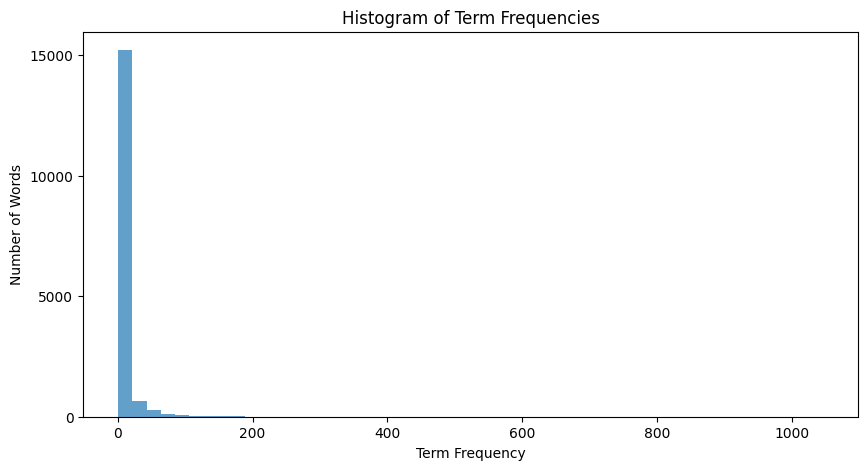

In [34]:
plt.figure(figsize=(10, 5))
plt.hist(word_totals, bins=50, alpha=0.7)
plt.title("Histogram of Term Frequencies")
plt.xlabel("Term Frequency")
plt.ylabel("Number of Words")
plt.yticks(range(0, 20000, 5000))
plt.show()

From this histogram and above analysis we see that most words appear very few times. There are about 15 000 (out of 16 000 unique words) that appears less than ~20 (1046/50) times - likely just once or twice. Then there are few bins of terms that are little common. The long low tail of high frequency words indicates that the number of more frequent words is extrimely low. <br>
To see if our thesis reagarding appearing once or twice is correct lets zoom on x-axis.

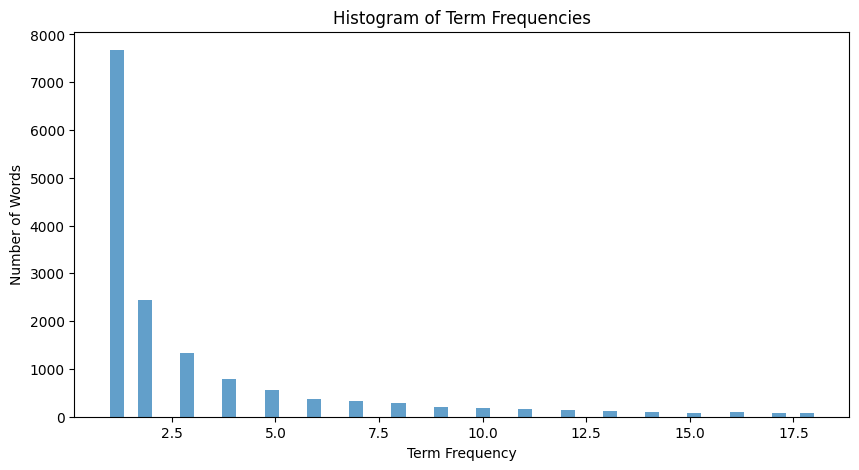

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(word_totals.sort_values().head(15000), bins=50, alpha=0.7)
plt.title("Histogram of Term Frequencies")
plt.xlabel("Term Frequency")
plt.ylabel("Number of Words")
plt.show()

In [43]:
len(word_totals[word_totals < 3])

10120

Now we see 15 000 of the least frequent terms and in fact most of them (about 10k) appears once or twice. That's typical for natural languages.
## **c) Document length distribution**

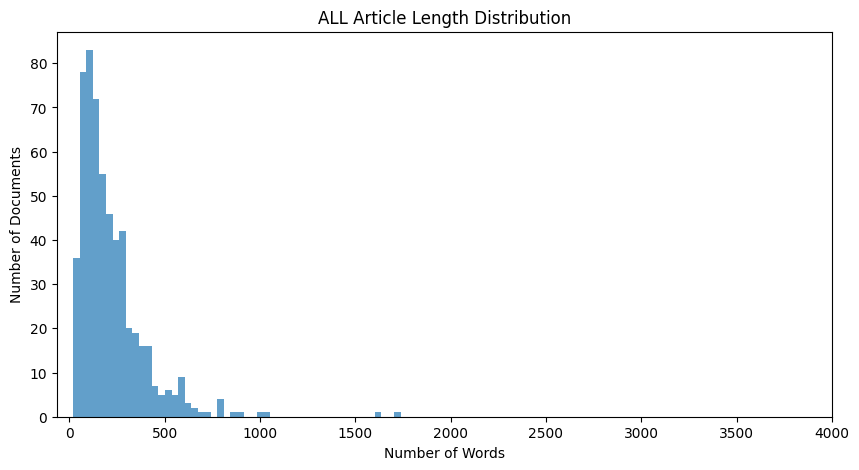

In [44]:
document_lengths = count_data.sum(axis=1)

plt.figure(figsize=(10, 5))
plt.hist(document_lengths, bins=50, alpha=0.7)
plt.title("ALL Article Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.xticks(range(0, 4500, 500))
plt.show()

Almost all articles are no longer than ~700 words (after preprocessing). Let's see if there is some significant difference in this distiribution across true and fake articles. <br>

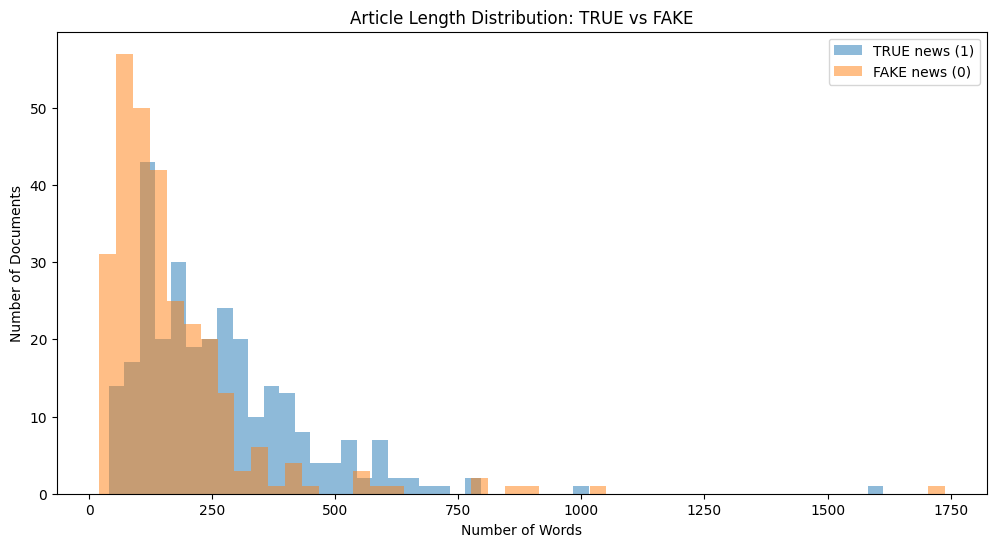

In [50]:
import matplotlib.pyplot as plt

true_lengths = count_data[y == 1].sum(axis=1)
fake_lengths = count_data[y == 0].sum(axis=1)

plt.figure(figsize=(12, 6))

plt.hist(true_lengths, bins=50, alpha=0.5, label="TRUE news (1)")
plt.hist(fake_lengths, bins=50, alpha=0.5, label="FAKE news (0)")

plt.title("Article Length Distribution: TRUE vs FAKE")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.legend()
plt.show()

We see that fake articles in general tend to be shorter than true ones.
## **d) Similarities between articles**

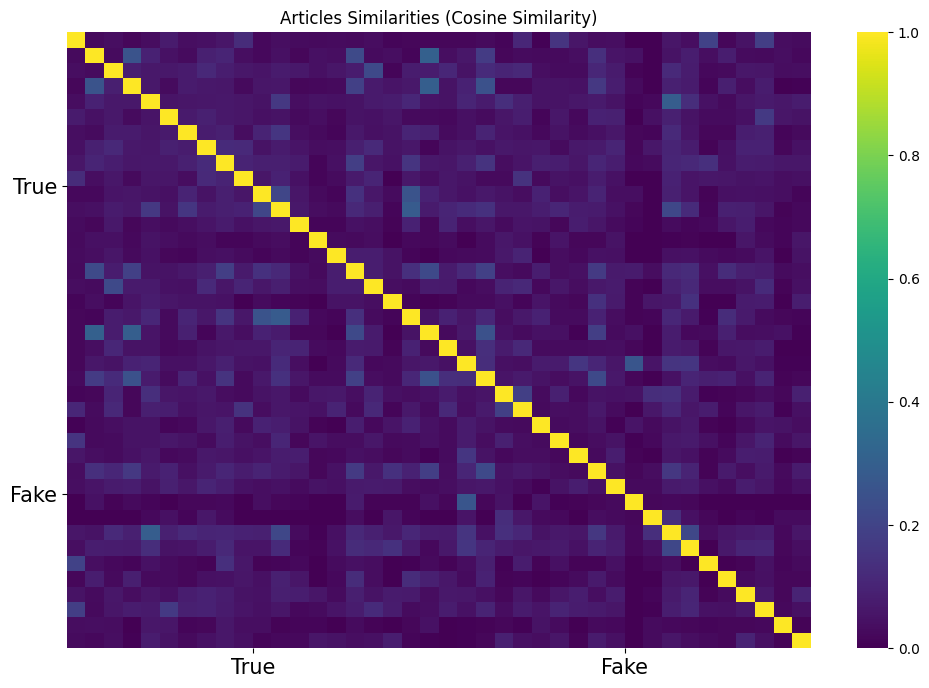

In [51]:
count_data_true = count_data[y == 1]
count_data_fake = count_data[y == 0]

true_sample = count_data_true.sample(n=20, random_state=42)
fake_sample = count_data_fake.sample(n=20, random_state=42)

similarity_matrix = cosine_similarity(pd.concat((true_sample, fake_sample)))

plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, cmap="viridis", xticklabels=False, yticklabels=False)
plt.xticks([10, 30], ['True', 'Fake'], size=15)
plt.yticks([10, 30], ['True', 'Fake'], size=15)
plt.title("Articles Similarities (Cosine Similarity)")
plt.show()

When comparing articles using only word-count features, the cosine-similarity heatmap shows no clear separation between true and fake news. Both groups use largely overlapping vocabulary, especially when discussing the same political or social topics. Because bag-of-words ignores meaning and only counts word frequencies, the representations of true and fake articles end up being very similar. As a consequence:
 * True vs True,
 * Fake vs Fake, and
 * True vs Fake

pairs all exhibit similarly low, noisy similarity values with no noticeable clusters or structure in the heatmap.

This confirms that simple lexical features cannot reliably distinguish real and false information—fake news intentionally mimics the vocabulary of real news, making them lexically alike.

Since word-level similarity fails to separate fake from true articles, using LLM-based semantic reasoning, as in MUSE, is essential for effective fake-news detection and correction.